<a href="https://colab.research.google.com/github/manuelec/nasdaq-prediction-pytorch/blob/main/Advanced_Time_Series_PyTorch_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Creation

In [64]:
# Install yfinance
# !pip install yfinance pandas-datareader

In [65]:
# Import libraries
import yfinance as yf
import pandas_datareader.data as web
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
from google.colab import auth
from google.auth import default
import gspread
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [66]:
#@title Download Data from yfinance
start_date = "2018-01-02"
end_date = "2024-12-01"

# Download NASDAQ and S&P 500 data from Yahoo Finance
nasdaq_data = yf.download("^IXIC", start=start_date, end=end_date)  # ^IXIC is the ticker for NASDAQ
sp500_data = yf.download("^GSPC", start=start_date, end=end_date)  # ^GSPC is the ticker for S&P 500

# Download Treasury yield and VIX from FRED
treasury_yield = web.DataReader("DGS10", "fred", start_date, end_date)
vix = web.DataReader("VIXCLS", "fred", start_date, end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [67]:
#@title Dataframe preparation
# Rename columns for clarity and to avoid duplicates
nasdaq_data = nasdaq_data.rename(columns={"Close": "nasdaq_close"})
sp500_data = sp500_data.rename(columns={"Close": "sp500_close"})

# Select the correct columns using the MultiIndex
nasdaq_close = nasdaq_data[('nasdaq_close', '^IXIC')]  # Accessing 'nasdaq_close' under 'Price' level and '^IXIC' under 'Ticker' level
sp500_close = sp500_data[('sp500_close', '^GSPC')]  # Accessing 'sp500_close' under 'Price' level and '^GSPC' under 'Ticker' level

# Convert the Series to DataFrames
nasdaq_close = pd.DataFrame(nasdaq_close)
sp500_close = pd.DataFrame(sp500_close)

# Merge the DataFrames
combined_df = nasdaq_close
combined_df = combined_df.join(sp500_close, how="left")

# Reset the index and flatten the MultiIndex columns
combined_df = combined_df.reset_index()
combined_df.columns = combined_df.columns.to_flat_index()

# Rename the columns
combined_df = combined_df.rename(
    columns={
        ("Date", ""): "Date",
        ("nasdaq_close", "^IXIC"): "nasdaq_close",
        ("sp500_close", "^GSPC"): "sp500_close",
    }
)

# Convert 'Date'
combined_df['Date'] = pd.to_datetime(combined_df['Date']).dt.tz_localize(None)

# Join with treasury_yield and vix
combined_df = combined_df.join(treasury_yield, how="left", on="Date")
combined_df = combined_df.join(vix, how="left", on="Date")

# Handle missing values (if any)
combined_df = combined_df.ffill()

# Print and check
print(combined_df.head())

        Date  nasdaq_close  sp500_close  DGS10  VIXCLS
0 2018-01-02   7006.899902  2695.810059   2.46    9.77
1 2018-01-03   7065.529785  2713.060059   2.44    9.15
2 2018-01-04   7077.910156  2723.989990   2.46    9.22
3 2018-01-05   7136.560059  2743.149902   2.47    9.22
4 2018-01-08   7157.390137  2747.709961   2.49    9.52


- uncomment if needed to export to Google Sheet, else leave it

In [68]:
#@title Export to Google Sheet and CSV locally
# # !pip install gspread oauth2client

# # Authenticate and create the Google Sheets connection
# auth.authenticate_user()
# creds, _ = default()
# gc = gspread.authorize(creds)

# # Create a new spreadsheet
# sh = gc.create('Combined_Dataset')

# # Open the spreadsheet
# worksheet = gc.open('Combined_Dataset').sheet1

# # Convert 'Date' column to string before exporting
# combined_df['date'] = combined_df['date'].astype(str)

# # Export the DataFrame to Google Sheets
# worksheet.update([combined_df.columns.values.tolist()] + combined_df.values.tolist())

# # Get the URL of the newly created spreadsheet
# spreadsheet_url = sh.url
# print(f"Spreadsheet URL: {spreadsheet_url}")

# exporting as csv for covenience in local folder
# combined_df.to_csv('./Combined_Dataset.csv', index=False)

<Axes: xlabel='Date'>

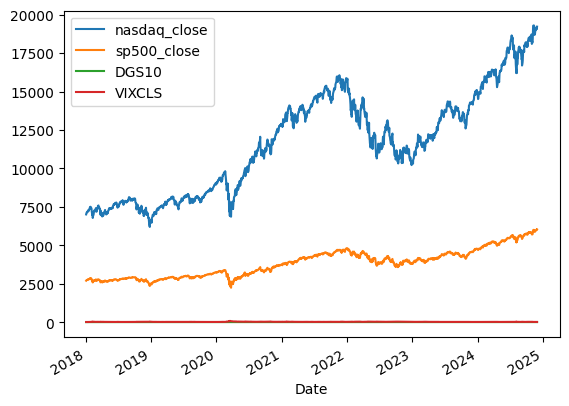

In [69]:
combined_df.plot(x='Date')



---





---



In [70]:
#@title Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import copy
import torch.nn.utils
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
# import BayesianOptimization
import random

In [71]:
#@title Set the dataset to use
# data = pd.read_csv('/content/Combined_Dataset.csv')
data = combined_df
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

In [72]:
#@title Create new derivate variable and handle NaN values in the data preprocessing stage
def preprocess_data(data):
    # Handle NaN values first
    data = data.ffill()  # Forward fill
    data = data.bfill()  # Backward fill for any remaining NaNs

    # Create engineered features
    data['log_nasdaq'] = np.log(data['nasdaq_close'])
    data['log_sp500'] = np.log(data['sp500_close'])
    data['nasdaq_returns'] = data['nasdaq_close'].pct_change()
    data['sp500_returns'] = data['sp500_close'].pct_change()
    data['nasdaq_volatility'] = data['nasdaq_returns'].rolling(window=21).std()
    data['nasdaq_ma50'] = data['nasdaq_close'].rolling(window=50).mean()
    data['sp500_ma50'] = data['sp500_close'].rolling(window=50).mean()
    data['relative_strength'] = data['nasdaq_close'] / data['sp500_close']

    # Fill NaN values created by rolling operations
    data = data.bfill()

    return data

# 2. Modify the scaling and sequence creation
# Apply preprocessing
data = preprocess_data(data)

## DataViz

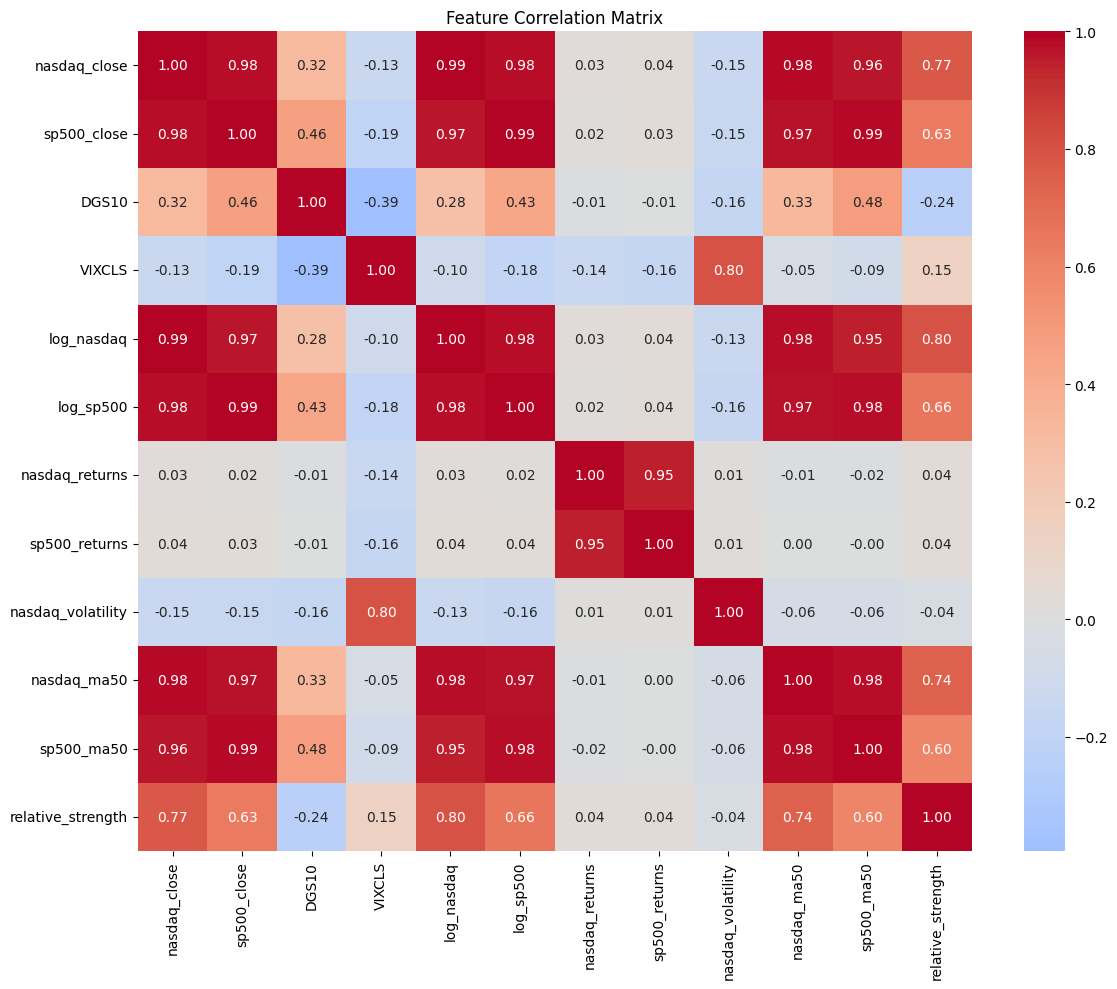

In [73]:
# Calculate correlation matrix for all features
correlation_matrix = data[[
    'nasdaq_close', 'sp500_close', 'DGS10', 'VIXCLS',
    'log_nasdaq', 'log_sp500', 'nasdaq_returns', 'sp500_returns',
    'nasdaq_volatility', 'nasdaq_ma50', 'sp500_ma50', 'relative_strength'
]].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [74]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f'Stationarity Test for {name}:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    print('-' * 40)

# Test stationarity for each feature
features_to_test = [
    'nasdaq_returns', 'sp500_returns', 'nasdaq_volatility',
    'relative_strength', 'log_nasdaq', 'log_sp500'
]

for feature in features_to_test:
    check_stationarity(data[feature], feature)

Stationarity Test for nasdaq_returns:
ADF Statistic: -13.3992
p-value: 0.0000
Critical Values:
	1%: -3.4341
	5%: -2.8632
	10%: -2.5677
----------------------------------------
Stationarity Test for sp500_returns:
ADF Statistic: -12.8402
p-value: 0.0000
Critical Values:
	1%: -3.4341
	5%: -2.8632
	10%: -2.5677
----------------------------------------
Stationarity Test for nasdaq_volatility:
ADF Statistic: -3.9244
p-value: 0.0019
Critical Values:
	1%: -3.4342
	5%: -2.8632
	10%: -2.5677
----------------------------------------
Stationarity Test for relative_strength:
ADF Statistic: -1.6821
p-value: 0.4403
Critical Values:
	1%: -3.4341
	5%: -2.8632
	10%: -2.5677
----------------------------------------
Stationarity Test for log_nasdaq:
ADF Statistic: -0.7004
p-value: 0.8467
Critical Values:
	1%: -3.4341
	5%: -2.8632
	10%: -2.5677
----------------------------------------
Stationarity Test for log_sp500:
ADF Statistic: -0.3750
p-value: 0.9142
Critical Values:
	1%: -3.4341
	5%: -2.8632
	10%: -

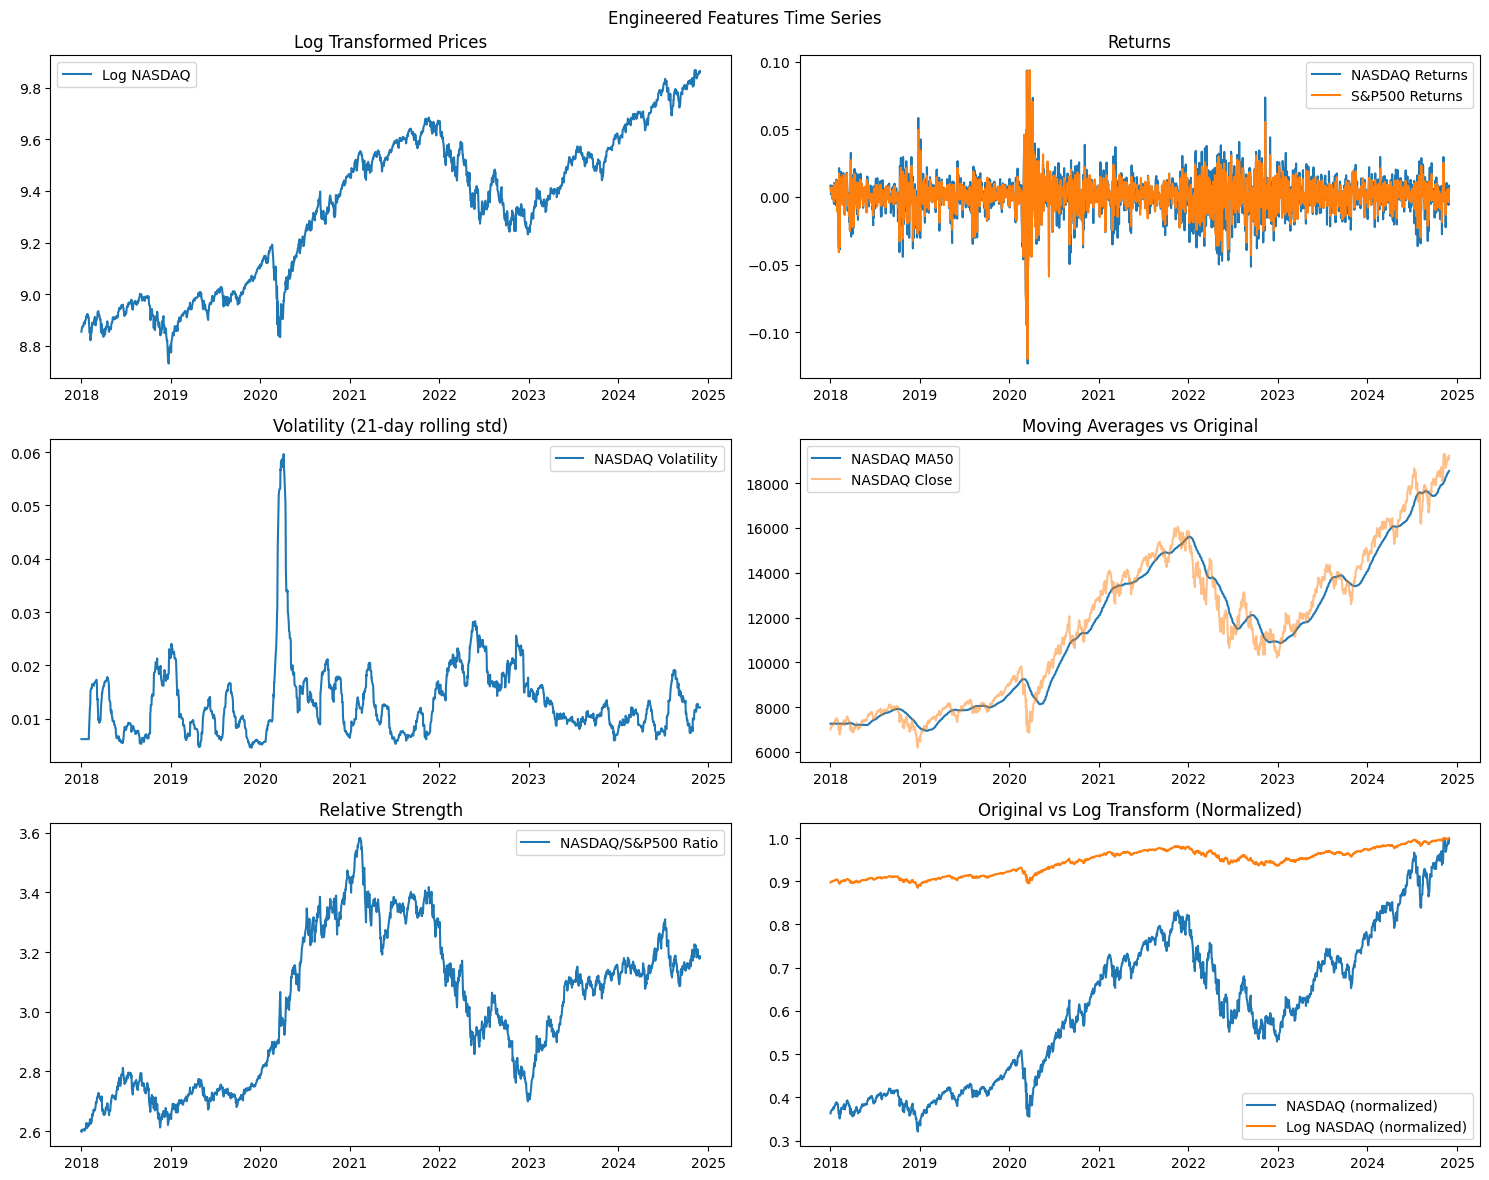

In [75]:
# Plot time series of engineered features
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Engineered Features Time Series')

# Log transformations
axes[0,0].plot(data.index, data['log_nasdaq'], label='Log NASDAQ')
axes[0,0].set_title('Log Transformed Prices')
axes[0,0].legend()

# Returns
axes[0,1].plot(data.index, data['nasdaq_returns'], label='NASDAQ Returns')
axes[0,1].plot(data.index, data['sp500_returns'], label='S&P500 Returns')
axes[0,1].set_title('Returns')
axes[0,1].legend()

# Volatility
axes[1,0].plot(data.index, data['nasdaq_volatility'], label='NASDAQ Volatility')
axes[1,0].set_title('Volatility (21-day rolling std)')
axes[1,0].legend()

# Moving averages
axes[1,1].plot(data.index, data['nasdaq_ma50'], label='NASDAQ MA50')
axes[1,1].plot(data.index, data['nasdaq_close'], label='NASDAQ Close', alpha=0.5)
axes[1,1].set_title('Moving Averages vs Original')
axes[1,1].legend()

# Relative strength
axes[2,0].plot(data.index, data['relative_strength'], label='NASDAQ/S&P500 Ratio')
axes[2,0].set_title('Relative Strength')
axes[2,0].legend()

# Original vs Log transformation comparison
axes[2,1].plot(data.index, data['nasdaq_close']/data['nasdaq_close'].max(),
               label='NASDAQ (normalized)')
axes[2,1].plot(data.index, data['log_nasdaq']/data['log_nasdaq'].max(),
               label='Log NASDAQ (normalized)')
axes[2,1].set_title('Original vs Log Transform (Normalized)')
axes[2,1].legend()

plt.tight_layout()
plt.show()

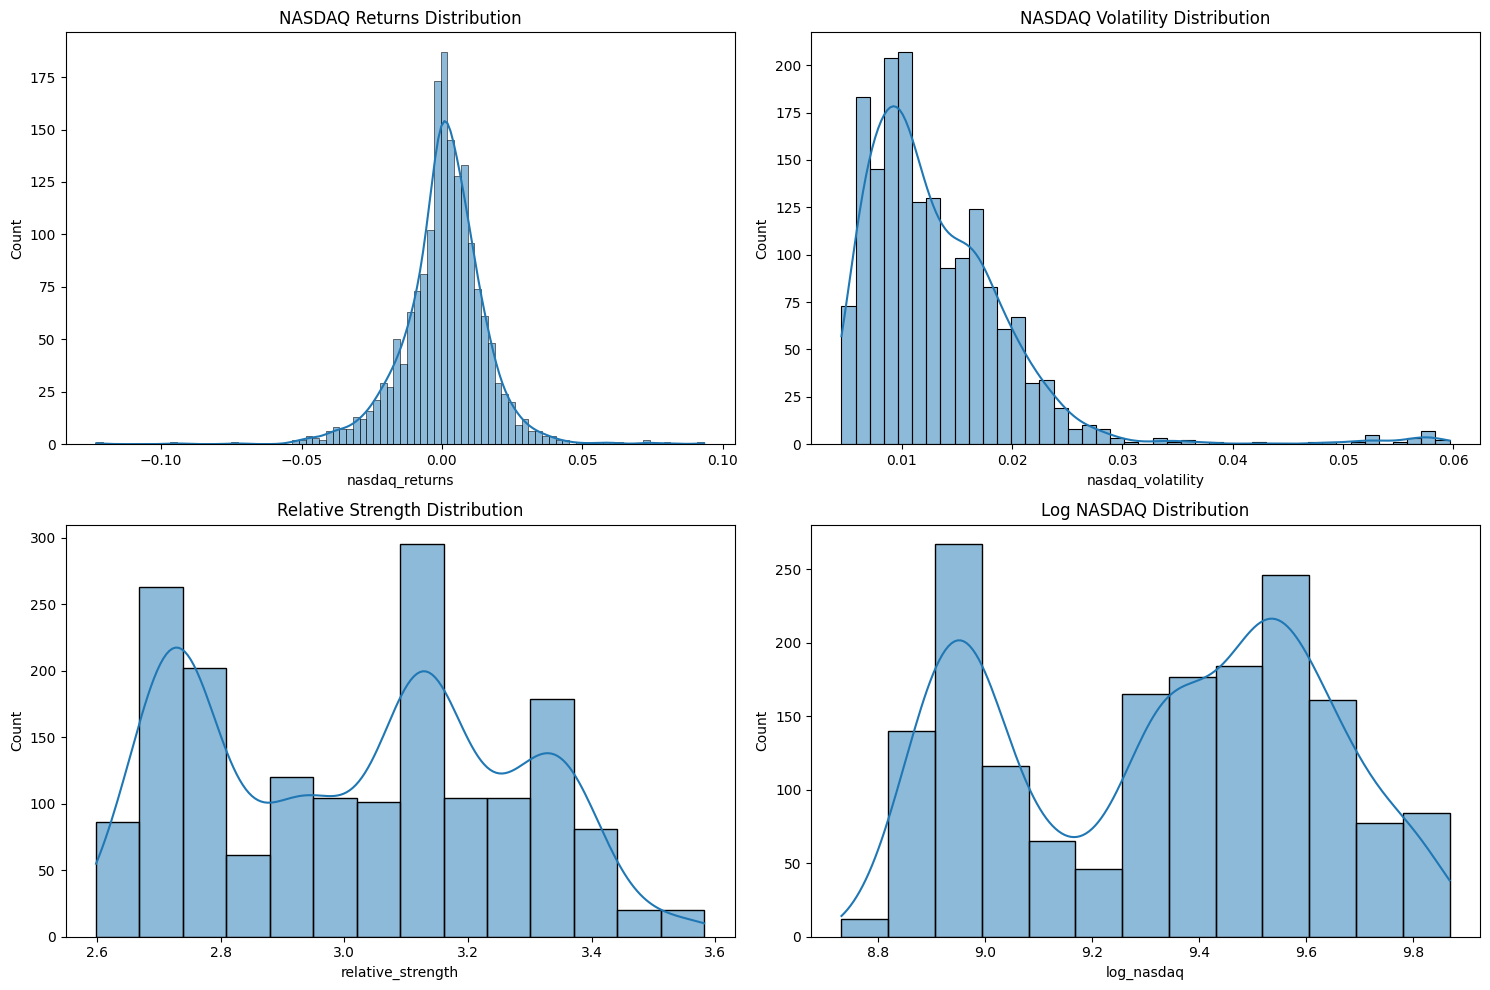

In [76]:
# Plot distribution of returns and volatility
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.histplot(data['nasdaq_returns'].dropna(), kde=True, ax=axes[0,0])
axes[0,0].set_title('NASDAQ Returns Distribution')

sns.histplot(data['nasdaq_volatility'].dropna(), kde=True, ax=axes[0,1])
axes[0,1].set_title('NASDAQ Volatility Distribution')

sns.histplot(data['relative_strength'].dropna(), kde=True, ax=axes[1,0])
axes[1,0].set_title('Relative Strength Distribution')

sns.histplot(data['log_nasdaq'].dropna(), kde=True, ax=axes[1,1])
axes[1,1].set_title('Log NASDAQ Distribution')

plt.tight_layout()
plt.show()



---



## Datasets creation (training, val, test)

In [77]:
#@title Define features and target
features = [
    'sp500_close', 'DGS10', 'VIXCLS',
    'log_sp500', 'sp500_returns', 'nasdaq_volatility',
    'sp500_ma50', 'relative_strength']

target = 'nasdaq_close'

# Get the column indices before scaling
feature_indices = [data.columns.get_loc(feature) for feature in features]
target_index = data.columns.get_loc(target)

- Validation Set: Used during training to monitor model performance and prevent overfitting. It represents 15% of the data  after the training set.
The validation set helps tune hyperparameters, while the test set provides an unbiased evaluation of the final model's performance.

- Test Set: Used only for final evaluation of the model's performance. It represents the last 15% of the data after the validation set.

We're creating a list of column indices for only these 8 selected features, excluding:
- nasdaq_close (target variable)
- log_nasdaq
- nasdaq_returns
- nasdaq_ma50

In [78]:
#@title Calculate split points for training, validation and test
total_days = len(data)
train_size = int(0.7 * total_days)
val_size = int(0.15 * total_days)
test_size = total_days - train_size - val_size

print(f"Total days: {total_days}")
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

Total days: 1740
Train size: 1218
Validation size: 261
Test size: 261


In [79]:
#@title Split Data into Training / Validation / Test
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

In [80]:
data.columns

Index(['nasdaq_close', 'sp500_close', 'DGS10', 'VIXCLS', 'log_nasdaq',
       'log_sp500', 'nasdaq_returns', 'sp500_returns', 'nasdaq_volatility',
       'nasdaq_ma50', 'sp500_ma50', 'relative_strength'],
      dtype='object')

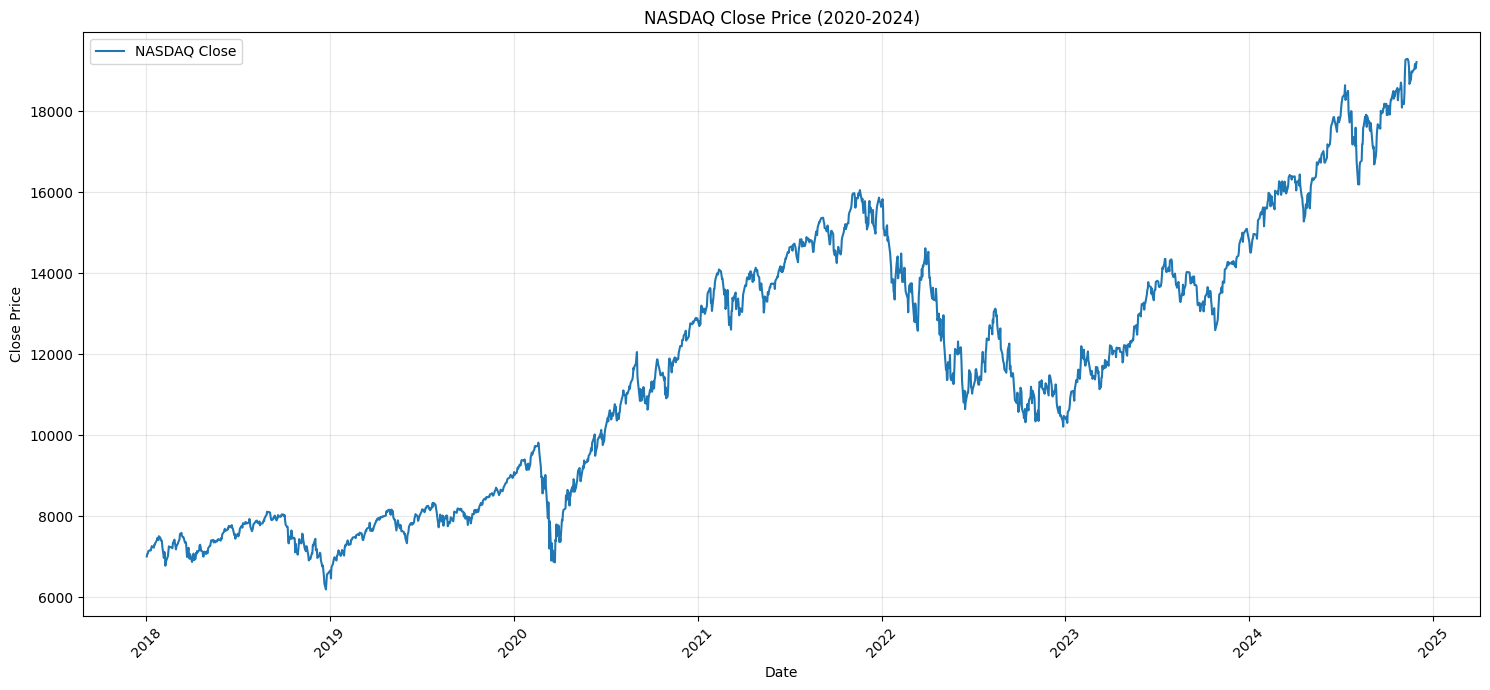

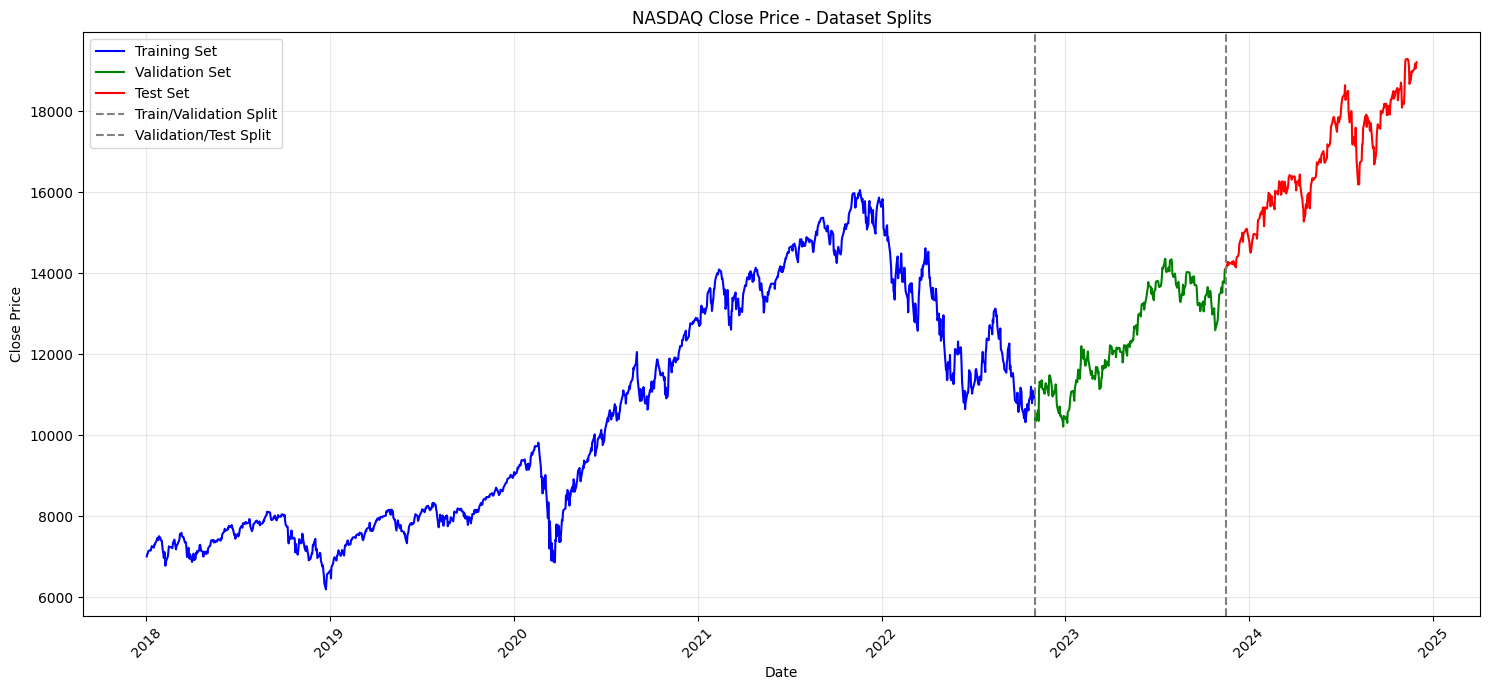

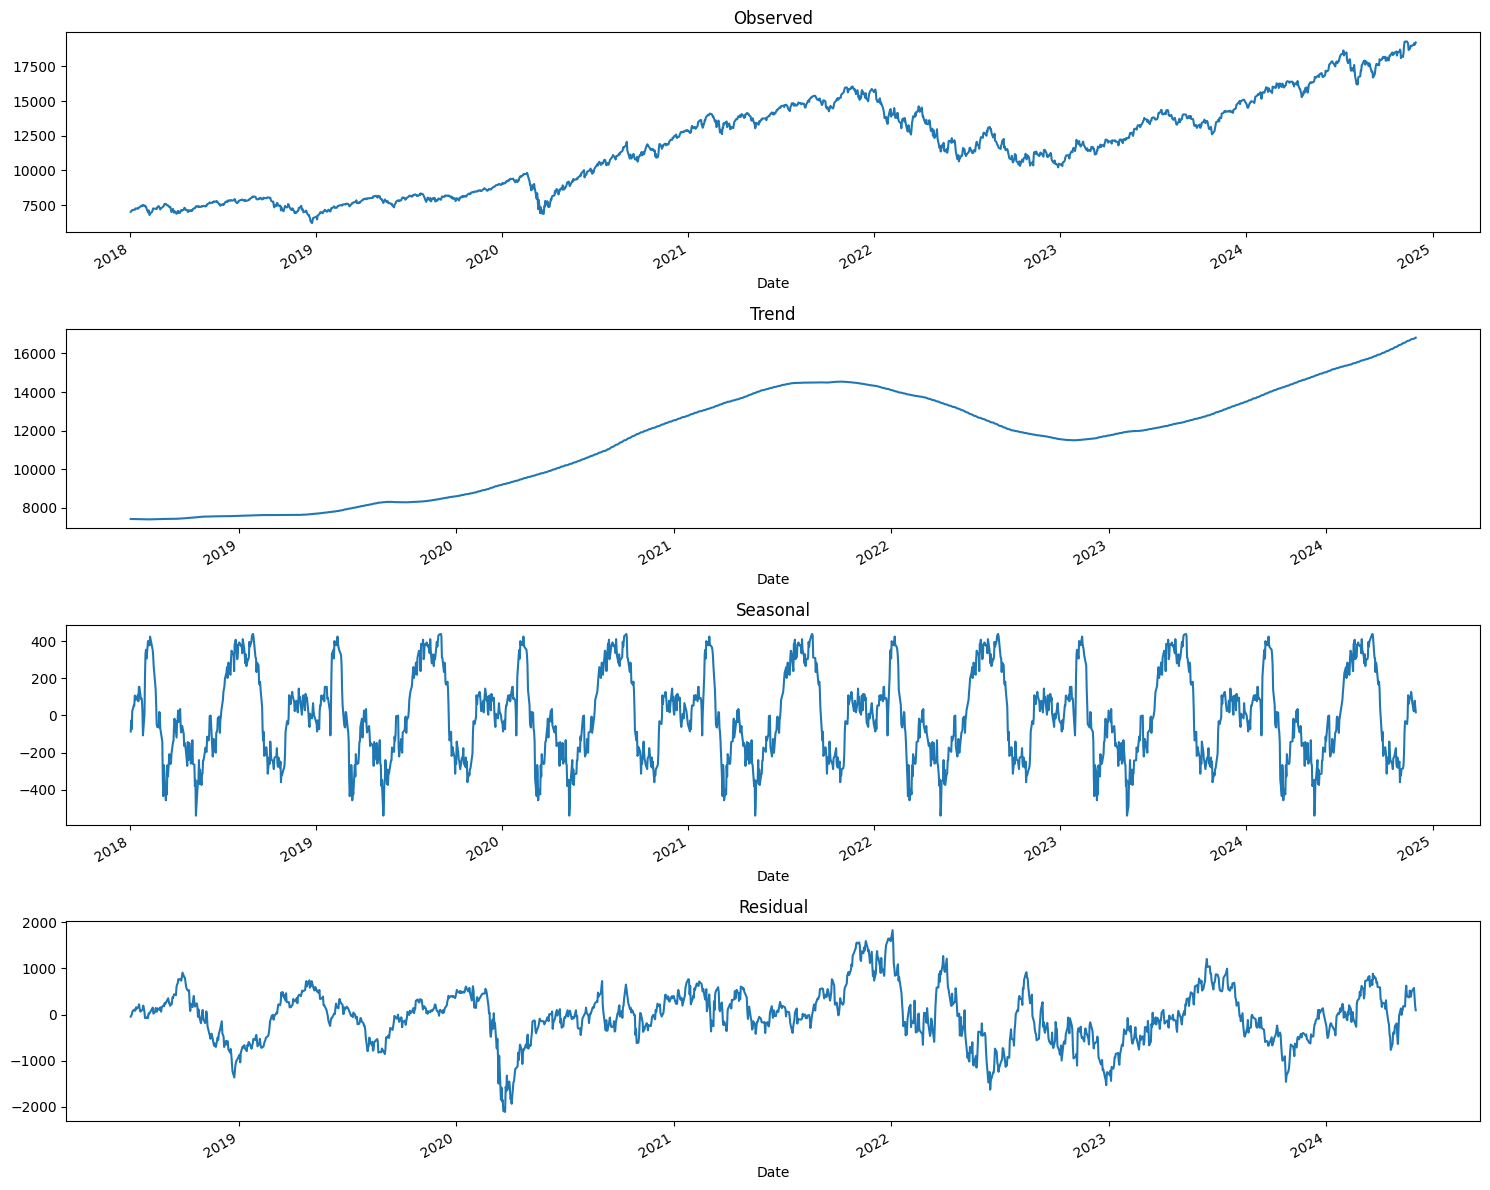

In [81]:
#@title DataViz Target time series split

plt.figure(figsize=(15, 7))
plt.plot(data.index, data['nasdaq_close'], label='NASDAQ Close')
plt.title('NASDAQ Close Price (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize train/validation/test splits
plt.figure(figsize=(15, 7))
plt.plot(data.index[:train_size], data['nasdaq_close'][:train_size],
         label='Training Set', color='blue')
plt.plot(data.index[train_size:train_size+val_size],
         data['nasdaq_close'][train_size:train_size+val_size],
         label='Validation Set', color='green')
plt.plot(data.index[train_size+val_size:],
         data['nasdaq_close'][train_size+val_size:],
         label='Test Set', color='red')
plt.axvline(x=data.index[train_size], color='gray', linestyle='--',
            label='Train/Validation Split')
plt.axvline(x=data.index[train_size+val_size], color='gray', linestyle='--',
            label='Validation/Test Split')
plt.title('NASDAQ Close Price - Dataset Splits')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Time series decomposition
decomposition = seasonal_decompose(data['nasdaq_close'], period=252)  # 252 trading days in a year

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

# Attention-based Neural Network for Time Series

In [82]:
#@title Scaling the data
scaler = MinMaxScaler(feature_range=(-1, 1))

scaled_train = scaler.fit_transform(train_data)
scaled_val = scaler.transform(val_data)
scaled_test = scaler.transform(test_data)



---



## Classes and Functions

In [83]:
#@title set fixed seed
def set_seeds(seed=42):
    # Python and NumPy
    random.seed(seed)
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

    return seed

# Apply seeds before creating DataLoaders
seed = set_seeds()

In [84]:
#@title Function Create sequences and check NaN
def create_sequences(data, seq_length, feature_indices, target_index):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length, feature_indices]
        target = data[i+seq_length, target_index]

        # Check for NaN values
        if not (np.isnan(seq).any() or np.isnan(target).any()):
            X.append(seq)
            y.append(target)

    return np.array(X), np.array(y)

In [85]:
#@title Class Create TimeSeriesDataset
class TimeSeriesDataset(Dataset):
    def __init__(self, features, target):
        self.features = torch.FloatTensor(features)
        self.target = torch.FloatTensor(target)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

In [86]:
#@title Function Add gradient normalization
def normalize_gradients(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** (1. / 2)
    return total_norm

In [87]:
#@title Function Train_and_validate
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, patience):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None
    accumulation_steps = 2
    warmup_epochs = 3

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    for epoch in range(epochs):
        # Warmup period
        if epoch < warmup_epochs:
            lr_scale = min(1., float(epoch + 1) / warmup_epochs)
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * pg['lr']

        # Training Phase
        model.train()
        train_loss = 0.0
        optimizer.zero_grad()

        for batch_idx, (data, target) in enumerate(train_loader):
            # Check for NaN values
            if torch.isnan(data).any() or torch.isnan(target).any():
                print(f"NaN values detected in batch {batch_idx}")
                continue

            output = model(data).squeeze()
            loss = criterion(output, target)

            # Gradient accumulation
            loss = loss / accumulation_steps
            loss.backward()

            grad_norm = normalize_gradients(model)
            if batch_idx % 10 == 0:
                print(f'Gradient norm: {grad_norm:.4f}')

            # Update weights after accumulation steps
            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

            train_loss += loss.item() * accumulation_steps

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}, Train Loss: {loss.item()*accumulation_steps:.4f}')

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data).squeeze()
                loss = criterion(output, target)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        # Save best model state
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = {
                'model': copy.deepcopy(model.state_dict()),
                'optimizer': copy.deepcopy(optimizer.state_dict()),
                'epoch': epoch,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss
            }
            patience_counter = 0
        else:
            patience_counter += 1

        print(f'Epoch {epoch+1}')
        print(f'Average Train Loss: {avg_train_loss:.4f}')
        print(f'Average Validation Loss: {avg_val_loss:.4f}')
        print('-' * 60)

        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    # Load best model state
    if best_state is not None:
        model.load_state_dict(best_state['model'])
        optimizer.load_state_dict(best_state['optimizer'])

    return model, train_losses, val_losses



---



## Neural Network

In [88]:
#@title Model 2 TimeAttention Model
class TimeSeriesAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.3):
        super(TimeSeriesAttention, self).__init__()
        self.hidden_size = hidden_size

        # Attention components
        self.attention = nn.Linear(hidden_size, 1)

        # Main network
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size = x.size(0)

        # Project to hidden space
        h = F.relu(self.bn1(self.fc1(x.view(batch_size, -1))))

        # Apply attention
        attention_weights = F.softmax(self.attention(h), dim=1)
        attended = h * attention_weights

        # Final prediction
        out = self.dropout(attended)
        return self.fc2(out)



---



**TimeSeriesAttention Handling of Variables:**

- The TimeSeriesAttention model processes the input data as follows:

- Takes the 8 selected features as input (sequence_length * len(features))
- Applies attention mechanism to focus on relevant temporal patterns
- Outputs a single value (NASDAQ close price prediction)


The model doesn't explicitly distinguish between target and covariates in its architecture - it learns the relationships through training

# Train the model

In [89]:
#@title Create sequences for each dataset
sequence_length = 10 # to change, initial setup
X_train, y_train = create_sequences(scaled_train, sequence_length, feature_indices, target_index)
X_val, y_val = create_sequences(scaled_val, sequence_length, feature_indices, target_index)
X_test, y_test = create_sequences(scaled_test, sequence_length, feature_indices, target_index)

In [90]:
#@title Create Datasets / Dataloaders

batch_size = 128  # Increased batch size for more stable gradients


train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)


# Modify DataLoader initialization
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Force single-thread operation
    generator=torch.Generator().manual_seed(seed)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    generator=torch.Generator().manual_seed(seed)
)


test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    generator=torch.Generator().manual_seed(seed)
)

In [91]:
#@title Model Parameters
input_size = sequence_length * len(features)  # xx * 8 = xx
hidden_size = 256  # hidden size
dropout_rate = 0.1
num_classes = 1
lr = 0.0003

In [92]:
#@title Define Model (Residual connections or Attention?)

# First model: residual connections
# model = MLPForTimeSeries(input_size, hidden_size, num_classes, dropout_rate)

# Second model: TimeSeriesAttention

model = TimeSeriesAttention(
    input_size=input_size,
    hidden_size=hidden_size,
    num_classes=1,
    dropout_rate=dropout_rate
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Gradient norm: 1.7176
Epoch 1, Batch 0, Train Loss: 0.0907
Epoch 1
Average Train Loss: 0.1040
Average Validation Loss: 0.0074
------------------------------------------------------------
Gradient norm: 2.6334
Epoch 2, Batch 0, Train Loss: 0.0801
Epoch 2
Average Train Loss: 0.1091
Average Validation Loss: 0.0125
------------------------------------------------------------
Gradient norm: 2.8113
Epoch 3, Batch 0, Train Loss: 0.1058
Epoch 3
Average Train Loss: 0.1190
Average Validation Loss: 0.0168
------------------------------------------------------------
Gradient norm: 2.5435
Epoch 4, Batch 0, Train Loss: 0.0761
Epoch 4
Average Train Loss: 0.1069
Average Validation Loss: 0.0172
------------------------------------------------------------
Gradient norm: 2.8215
Epoch 5, Batch 0, Train Loss: 0.1037
Epoch 5
Average Train Loss: 0.1094
Average Validation Loss: 0.0176
------------------------------------------------------------
Gradient norm: 3.2136
Epoch 6, Batch 0, Train Loss: 0.1443
Epoch 

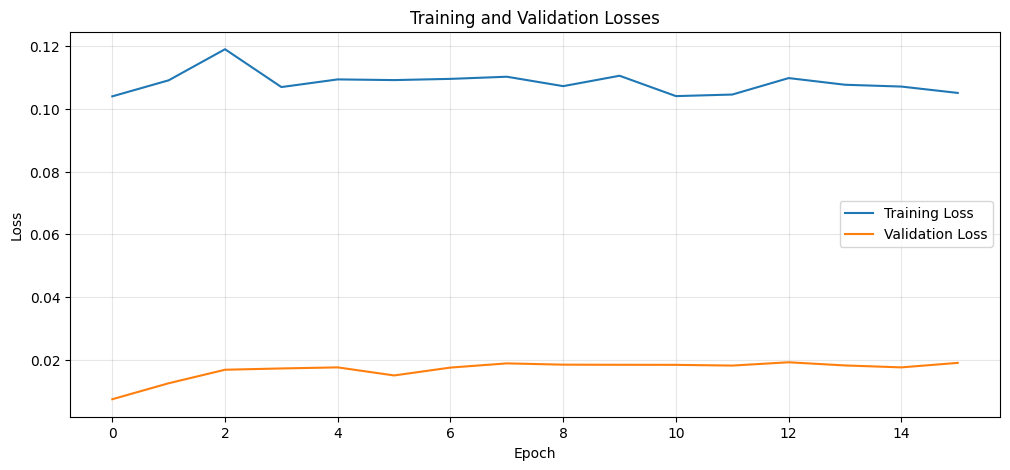

In [104]:
#@title Train the Model >>>
epochs = 60
patience = 15
model, train_losses, val_losses = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, epochs, patience
)


# Plot training curves
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



---



## Make predictions

The data_columns utilized in make_predictions is primarily used in the make_predictions function to:
- Create dummy arrays for inverse transformation
- Locate the nasdaq_close index
- Transform predictions back to original scale

The model itself only sees the 8 selected features during training and prediction.


Validation Set Performance Metrics:
MSE: 179074.32
RMSE: 423.17
MAE: 314.94
R2 Score: 0.8594


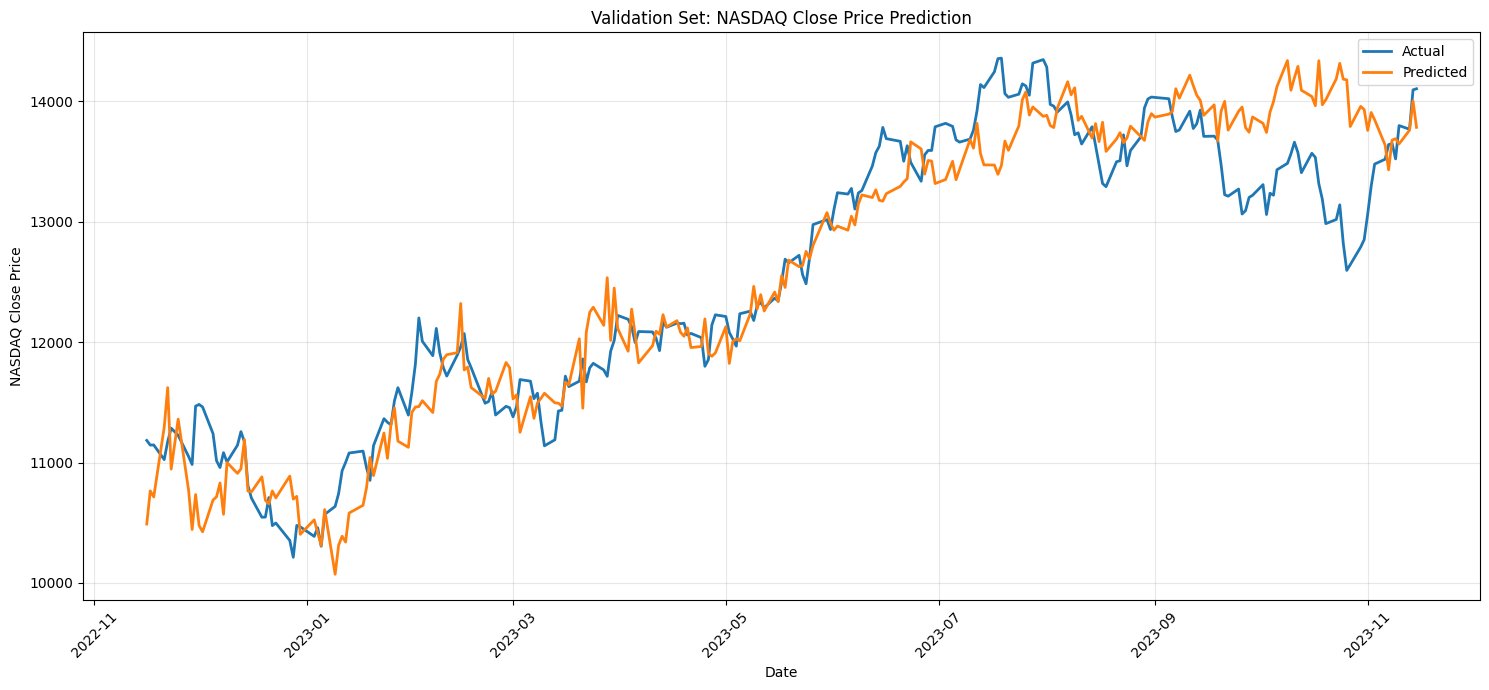


Test Set Performance Metrics:
MSE: 874491.32
RMSE: 935.14
MAE: 830.74
R2 Score: 0.4887


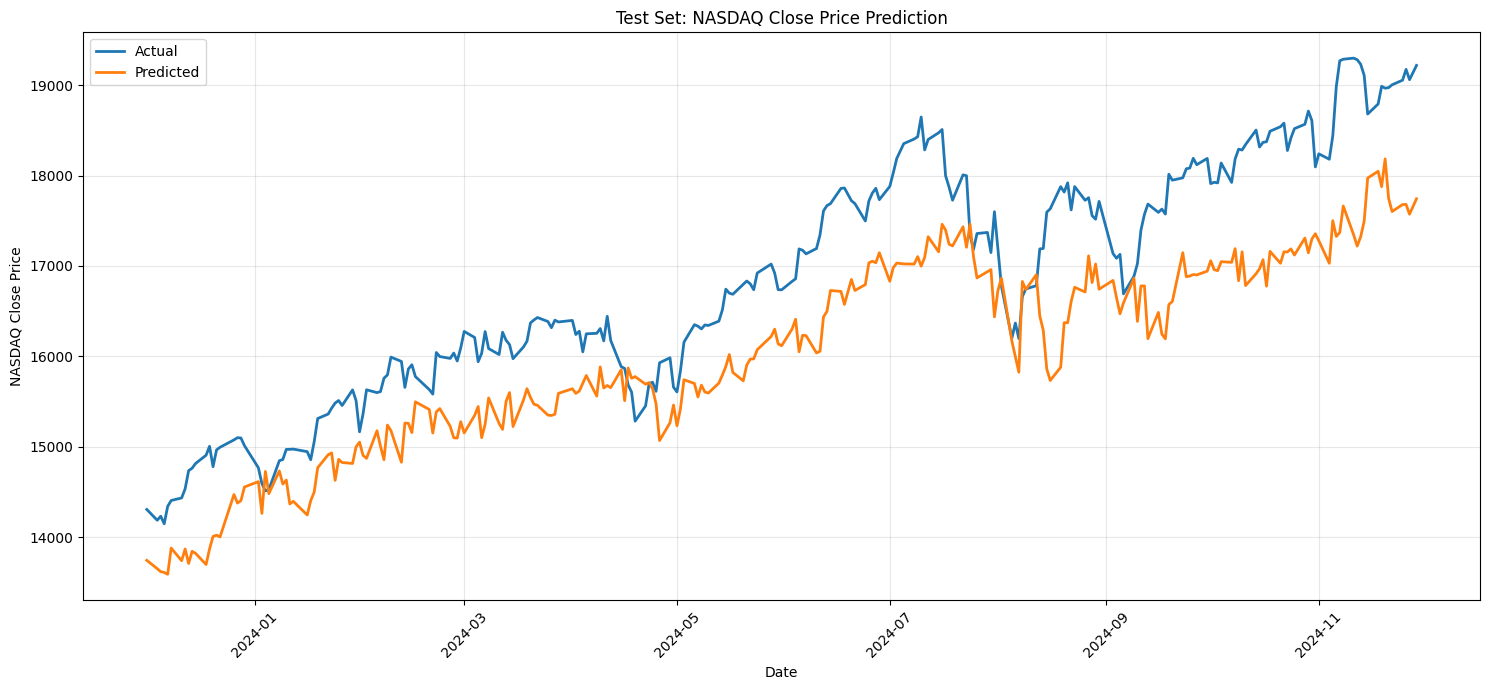

In [105]:
#@title Make predictions on Eval and Test, performance metrics and DataViz
def make_predictions(model, data_loader, scaler, data_columns):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for features, targets in data_loader:
            output = model(features).squeeze()
            predictions.extend(output.numpy())
            actuals.extend(targets.numpy())

    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)

    predictions_dummy = np.zeros((len(predictions), len(data_columns)))
    actuals_dummy = np.zeros((len(actuals), len(data_columns)))

    nasdaq_idx = data_columns.index('nasdaq_close')
    predictions_dummy[:, nasdaq_idx] = predictions[:, 0]
    actuals_dummy[:, nasdaq_idx] = actuals[:, 0]

    predictions = scaler.inverse_transform(predictions_dummy)[:, nasdaq_idx]
    actuals = scaler.inverse_transform(actuals_dummy)[:, nasdaq_idx]

    return predictions, actuals

# Define metrics calculation
def calculate_metrics(y_true, y_pred, set_name=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{set_name} Performance Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R2 Score: {r2:.4f}")

    return mse, rmse, mae, r2

# Define data columns
data_columns = [
    'nasdaq_close', 'sp500_close', 'DGS10', 'VIXCLS',
    'log_nasdaq', 'log_sp500', 'nasdaq_returns', 'sp500_returns',
    'nasdaq_volatility', 'nasdaq_ma50', 'sp500_ma50', 'relative_strength'
]

##########################################################################


# Validation Set Evaluation
val_predictions, val_actuals = make_predictions(model, val_loader, scaler, data_columns)
val_metrics = calculate_metrics(val_actuals, val_predictions, "Validation Set")

# Plot validation predictions
plt.figure(figsize=(15, 7))
val_dates = data.index[train_size:train_size+val_size][-len(val_predictions):]
plt.plot(val_dates, val_actuals, label='Actual', linewidth=2)
plt.plot(val_dates, val_predictions, label='Predicted', linewidth=2)
plt.title('Validation Set: NASDAQ Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('NASDAQ Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Test Set Evaluation
test_predictions, test_actuals = make_predictions(model, test_loader, scaler, data_columns)
test_metrics = calculate_metrics(test_actuals, test_predictions, "Test Set")

# Plot test predictions
plt.figure(figsize=(15, 7))
test_dates = data.index[train_size+val_size:][-len(test_predictions):]
plt.plot(test_dates, test_actuals, label='Actual', linewidth=2)
plt.plot(test_dates, test_predictions, label='Predicted', linewidth=2)
plt.title('Test Set: NASDAQ Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('NASDAQ Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



---



# Parameter Optimization



---



In [113]:
#@title Grid Search Function for TimeAttention Model
def grid_search_parameters(train_loader, val_loader):
    param_grid = {
        'sequence_length': [10, 15, 20],
        'hidden_size': [64, 128, 256],
        'learning_rate': [0.0001, 0.0003],
        'batch_size': [32, 64, 128],
        'dropout_rate': [0.1, 0.2, 0.4]
    }

    results = []
    best_val_loss = float('inf')
    best_params = None

    # Set seeds for reproducibility
    seed_worker = set_seeds(42)
    g = torch.Generator()
    g.manual_seed(42)

    for seq_len in param_grid['sequence_length']:
        # Recreate sequences with current sequence length
        X_train, y_train = create_sequences(scaled_train, seq_len, feature_indices, target_index)
        X_val, y_val = create_sequences(scaled_val, seq_len, feature_indices, target_index)

        for batch in param_grid['batch_size']:
            # Create new dataloaders with current batch size
            train_dataset = TimeSeriesDataset(X_train, y_train)
            val_dataset = TimeSeriesDataset(X_val, y_val)
            current_train_loader = DataLoader(
                train_dataset,
                batch_size=batch,
                shuffle=True,
                worker_init_fn=seed_worker,
                generator=g
            )
            current_val_loader = DataLoader(
                val_dataset,
                batch_size=batch,
                shuffle=False,
                worker_init_fn=seed_worker,
                generator=g
            )

            for hidden in param_grid['hidden_size']:
                for lr in param_grid['learning_rate']:
                    for dropout in param_grid['dropout_rate']:
                        # Initialize TimeSeriesAttention model
                        model = TimeSeriesAttention(
                            input_size=seq_len * len(features),
                            hidden_size=hidden,
                            num_classes=1,
                            dropout_rate=dropout
                        )

                        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
                        criterion = nn.MSELoss()

                        # Train model
                        model, train_losses, val_losses = train_and_validate(
                            model, current_train_loader, current_val_loader,
                            criterion, optimizer, epochs=20, patience=5
                        )

                        # Record results
                        final_val_loss = val_losses[-1]
                        results.append({
                            'sequence_length': seq_len,
                            'batch_size': batch,
                            'hidden_size': hidden,
                            'learning_rate': lr,
                            'dropout_rate': dropout,
                            'val_loss': final_val_loss
                        })

                        if final_val_loss < best_val_loss:
                            best_val_loss = final_val_loss
                            best_params = {
                                'sequence_length': seq_len,
                                'batch_size': batch,
                                'hidden_size': hidden,
                                'learning_rate': lr,
                                'dropout_rate': dropout
                            }

                        print(f"Completed trial with parameters: {results[-1]}")

    return best_params, results

In [135]:
#@title Call the grid search
best_params, search_results = grid_search_parameters(train_loader, val_loader) #changed to test loader vs val loader
print("Best parameters:", best_params)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Output streaming troncato alle ultime 5000 righe.
------------------------------------------------------------
Gradient norm: 0.7293
Epoch 7, Batch 0, Train Loss: 0.0930
Gradient norm: 0.7043
Epoch 7, Batch 10, Train Loss: 0.0896
Gradient norm: 0.6639
Epoch 7, Batch 20, Train Loss: 0.0833
Gradient norm: 1.6932
Epoch 7, Batch 30, Train Loss: 0.1598
Epoch 7
Average Train Loss: 0.1003
Average Validation Loss: 0.0309
------------------------------------------------------------
Gradient norm: 1.0133
Epoch 8, Batch 0, Train Loss: 0.1049
Gradient norm: 1.1846
Epoch 8, Batch 10, Train Loss: 0.1351
Gradient norm: 1.1124
Epoch 8, Batch 20, Train Loss: 0.0847
Gradient norm: 1.1460
Epoch 8, Batch 30, Train Loss: 0.1042
Epoch 8
Average Train Loss: 0.0943
Average Validation Loss: 0.0390
------------------------------------------------------------
Gradient norm: 0.6903
Epoch 9, Batch 0, Train Loss: 0.0987
Gradient norm: 0.6925
Epoch 9, Batch 10, Train Loss: 0.0911
Gradient norm: 0.5718
Epoch 9, Batch

In [136]:
print(best_params)

{'sequence_length': 10, 'batch_size': 32, 'hidden_size': 128, 'learning_rate': 0.0003, 'dropout_rate': 0.2}


## Cross Validation for TimeAttention model

In [137]:
#@title Function time_series Cross Validation
def time_series_cv(data, best_params, n_splits=5):
    # Calculate the size of each fold
    fold_size = len(data) // (n_splits + 1)
    cv_results = []

    # Set seeds for reproducibility
    seed_worker = set_seeds(42)
    g = torch.Generator()
    g.manual_seed(42)

    for i in range(n_splits):
        # Calculate indices for this fold
        train_end = (i + 1) * fold_size
        val_end = train_end + fold_size

        # Split data
        train_fold = data[:train_end]
        val_fold = data[train_end:val_end]

        # Scale the data
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled_train = scaler.fit_transform(train_fold)
        scaled_val = scaler.transform(val_fold)

        # Create sequences with best sequence length
        X_train, y_train = create_sequences(
            scaled_train,
            best_params['sequence_length'],
            feature_indices,
            target_index
        )
        X_val, y_val = create_sequences(
            scaled_val,
            best_params['sequence_length'],
            feature_indices,
            target_index
        )

        # Create datasets and dataloaders
        train_dataset = TimeSeriesDataset(X_train, y_train)
        val_dataset = TimeSeriesDataset(X_val, y_val)

        train_loader = DataLoader(
            train_dataset,
            batch_size=best_params['batch_size'],
            shuffle=True,
            num_workers=0,
            generator=g
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=best_params['batch_size'],
            shuffle=False,
            num_workers=0,
            generator=g
        )

        # Initialize model with best parameters
        model = TimeSeriesAttention(
            input_size=best_params['sequence_length'] * len(features),
            hidden_size=best_params['hidden_size'],
            num_classes=1,
            dropout_rate=best_params['dropout_rate']
        )

        optimizer = optim.Adam(
            model.parameters(),
            lr=best_params['learning_rate'],
            weight_decay=1e-5
        )
        criterion = nn.MSELoss()

        # Train model
        model, train_losses, val_losses = train_and_validate(
            model, train_loader, val_loader, criterion,
            optimizer, epochs=20, patience=5
        )

        # Store results with parameters
        cv_results.append({
            'fold': i+1,
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1],
            'sequence_length': best_params['sequence_length'],
            'hidden_size': best_params['hidden_size'],
            'learning_rate': best_params['learning_rate'],
            'batch_size': best_params['batch_size'],
            'dropout_rate': best_params['dropout_rate'],
            'model': model
        })

        print(f"Fold {i+1}")
        print(f"Training Loss: {train_losses[-1]:.4f}")
        print(f"Validation Loss: {val_losses[-1]:.4f}")
        print("-" * 40)

    return cv_results

In [138]:
#@title Cross-validation with best parameters
cv_results = time_series_cv(data, best_params)

# Print results for each fold
for result in cv_results:
    print(f"Fold {result['fold']}")
    print(f"Parameters:")
    print(f"- Sequence Length: {result['sequence_length']}")
    print(f"- Hidden Size: {result['hidden_size']}")
    print(f"- Learning Rate: {result['learning_rate']}")
    print(f"- Batch Size: {result['batch_size']}")
    print(f"- Dropout Rate: {result['dropout_rate']}")
    print(f"Training Loss: {result['train_loss']:.4f}")
    print(f"Validation Loss: {result['val_loss']:.4f}")
    print("-" * 40)

Gradient norm: 3.4574
Epoch 1, Batch 0, Train Loss: 0.5947
Epoch 1
Average Train Loss: 0.3645
Average Validation Loss: 1.8730
------------------------------------------------------------
Gradient norm: 2.3615
Epoch 2, Batch 0, Train Loss: 0.3070
Epoch 2
Average Train Loss: 0.2994
Average Validation Loss: 1.8671
------------------------------------------------------------
Gradient norm: 2.3847
Epoch 3, Batch 0, Train Loss: 0.2814
Epoch 3
Average Train Loss: 0.2671
Average Validation Loss: 1.7794
------------------------------------------------------------
Gradient norm: 2.2063
Epoch 4, Batch 0, Train Loss: 0.2460
Epoch 4
Average Train Loss: 0.2159
Average Validation Loss: 1.7088
------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Gradient norm: 1.5539
Epoch 5, Batch 0, Train Loss: 0.1663
Epoch 5
Average Train Loss: 0.2072
Average Validation Loss: 1.5640
------------------------------------------------------------
Gradient norm: 1.6282
Epoch 6, Batch 0, Train Loss: 0.1973
Epoch 6
Average Train Loss: 0.1707
Average Validation Loss: 1.4201
------------------------------------------------------------
Gradient norm: 1.5167
Epoch 7, Batch 0, Train Loss: 0.1473
Epoch 7
Average Train Loss: 0.1711
Average Validation Loss: 1.3039
------------------------------------------------------------
Gradient norm: 0.8373
Epoch 8, Batch 0, Train Loss: 0.0807
Epoch 8
Average Train Loss: 0.1575
Average Validation Loss: 1.3432
------------------------------------------------------------
Gradient norm: 0.8856
Epoch 9, Batch 0, Train Loss: 0.0718
Epoch 9
Average Train Loss: 0.1414
Average Validation Loss: 1.3410
------------------------------------------------------------
Gradient norm: 1.1946
Epoch 10, Batch 0, Train Loss: 0.1534
Epoch

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1
Average Train Loss: 0.3215
Average Validation Loss: 6.6606
------------------------------------------------------------
Gradient norm: 2.6686
Epoch 2, Batch 0, Train Loss: 0.2018
Gradient norm: 2.0199
Epoch 2, Batch 10, Train Loss: 0.1900
Epoch 2
Average Train Loss: 0.1809
Average Validation Loss: 6.2868
------------------------------------------------------------
Gradient norm: 1.5210
Epoch 3, Batch 0, Train Loss: 0.1381
Gradient norm: 1.5059
Epoch 3, Batch 10, Train Loss: 0.1600
Epoch 3
Average Train Loss: 0.1217
Average Validation Loss: 4.6465
------------------------------------------------------------
Gradient norm: 1.1869
Epoch 4, Batch 0, Train Loss: 0.1044
Gradient norm: 0.6485
Epoch 4, Batch 10, Train Loss: 0.0657
Epoch 4
Average Train Loss: 0.0922
Average Validation Loss: 3.1326
------------------------------------------------------------
Gradient norm: 1.1662
Epoch 5, Batch 0, Train Loss: 0.0634
Gradient norm: 0.8711
Epoch 5, Batch 10, Train Loss: 0.0765
Epoch 5
Aver

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Gradient norm: 1.8740
Epoch 2, Batch 10, Train Loss: 0.1918
Gradient norm: 1.6871
Epoch 2, Batch 20, Train Loss: 0.1345
Epoch 2
Average Train Loss: 0.2166
Average Validation Loss: 0.0942
------------------------------------------------------------
Gradient norm: 1.5723
Epoch 3, Batch 0, Train Loss: 0.1428
Gradient norm: 1.7681
Epoch 3, Batch 10, Train Loss: 0.2090
Gradient norm: 2.0607
Epoch 3, Batch 20, Train Loss: 0.1951
Epoch 3
Average Train Loss: 0.1503
Average Validation Loss: 0.2424
------------------------------------------------------------
Gradient norm: 1.7838
Epoch 4, Batch 0, Train Loss: 0.1625
Gradient norm: 1.3915
Epoch 4, Batch 10, Train Loss: 0.0996
Gradient norm: 1.0533
Epoch 4, Batch 20, Train Loss: 0.0891
Epoch 4
Average Train Loss: 0.1130
Average Validation Loss: 0.3112
------------------------------------------------------------
Gradient norm: 1.8717
Epoch 5, Batch 0, Train Loss: 0.1764
Gradient norm: 0.8519
Epoch 5, Batch 10, Train Loss: 0.0581
Gradient norm: 1.47

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Gradient norm: 1.5792
Epoch 2, Batch 20, Train Loss: 0.1425
Gradient norm: 1.2216
Epoch 2, Batch 30, Train Loss: 0.1780
Epoch 2
Average Train Loss: 0.1070
Average Validation Loss: 0.0974
------------------------------------------------------------
Gradient norm: 0.8140
Epoch 3, Batch 0, Train Loss: 0.0620
Gradient norm: 0.6076
Epoch 3, Batch 10, Train Loss: 0.0581
Gradient norm: 0.6513
Epoch 3, Batch 20, Train Loss: 0.0663
Gradient norm: 1.4245
Epoch 3, Batch 30, Train Loss: 0.1225
Epoch 3
Average Train Loss: 0.0755
Average Validation Loss: 0.0959
------------------------------------------------------------
Gradient norm: 0.7693
Epoch 4, Batch 0, Train Loss: 0.0731
Gradient norm: 0.7060
Epoch 4, Batch 10, Train Loss: 0.0771
Gradient norm: 1.0076
Epoch 4, Batch 20, Train Loss: 0.0801
Gradient norm: 1.1703
Epoch 4, Batch 30, Train Loss: 0.0688
Epoch 4
Average Train Loss: 0.0686
Average Validation Loss: 0.1003
------------------------------------------------------------
Gradient norm: 0.5

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1
Average Train Loss: 0.7433
Average Validation Loss: 3.4864
------------------------------------------------------------
Gradient norm: 3.0139
Epoch 2, Batch 0, Train Loss: 0.4819
Gradient norm: 3.0646
Epoch 2, Batch 10, Train Loss: 0.2982
Gradient norm: 1.8809
Epoch 2, Batch 20, Train Loss: 0.1564
Gradient norm: 1.9121
Epoch 2, Batch 30, Train Loss: 0.1979
Gradient norm: 1.0417
Epoch 2, Batch 40, Train Loss: 0.0892
Epoch 2
Average Train Loss: 0.2343
Average Validation Loss: 1.0253
------------------------------------------------------------
Gradient norm: 1.1582
Epoch 3, Batch 0, Train Loss: 0.0860
Gradient norm: 1.4674
Epoch 3, Batch 10, Train Loss: 0.1488
Gradient norm: 0.5594
Epoch 3, Batch 20, Train Loss: 0.0672
Gradient norm: 0.7731
Epoch 3, Batch 30, Train Loss: 0.0941
Gradient norm: 1.0109
Epoch 3, Batch 40, Train Loss: 0.0741
Epoch 3
Average Train Loss: 0.1023
Average Validation Loss: 0.2566
------------------------------------------------------------
Gradient norm: 1.1



---



Best parameters: {'sequence_length': 10, 'batch_size': 128, 'hidden_size': 256, 'learning_rate': 0.0003, 'dropout_rate': 0.1}



In [139]:
print(best_params)

{'sequence_length': 10, 'batch_size': 32, 'hidden_size': 128, 'learning_rate': 0.0003, 'dropout_rate': 0.2}


# Implement best params

In [140]:
#@title Implement best params to TimeSeriesAttention, DataLoader, Optimizer

# Initialize final model with best parameters
final_model = TimeSeriesAttention(
    input_size=best_params['sequence_length'] * len(features),
    hidden_size=best_params['hidden_size'],
    num_classes=1,
    dropout_rate=best_params['dropout_rate']
)

# Create dataloaders with optimal batch size
train_loader = DataLoader(
    train_dataset,
    batch_size=best_params['batch_size'],
    shuffle=True,
    num_workers=0,
    generator=torch.Generator().manual_seed(42)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=best_params['batch_size'],
    shuffle=False,
    num_workers=0,
    generator=torch.Generator().manual_seed(42)
)

test_loader = DataLoader(
    test_dataset,
    batch_size=best_params['batch_size'],
    shuffle=False,
    num_workers=0,
    generator=torch.Generator().manual_seed(42)
)

# Initialize optimizer with best learning rate
optimizer = optim.Adam(
    final_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=1e-5
)

In [141]:
#@title Train with optimal parameters and early using leveraging Val Dataset
epochs = 50
patience = 12
criterion = nn.MSELoss()

final_model, train_losses, val_losses = train_and_validate(
    final_model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs,
    patience
)


Gradient norm: 5.9040
Epoch 1, Batch 0, Train Loss: 1.1362
Gradient norm: 4.9196
Epoch 1, Batch 10, Train Loss: 1.0183
Gradient norm: 5.1572
Epoch 1, Batch 20, Train Loss: 1.0191
Gradient norm: 4.3497
Epoch 1, Batch 30, Train Loss: 0.7106
Epoch 1
Average Train Loss: 0.9893
Average Validation Loss: 0.0639
------------------------------------------------------------
Gradient norm: 4.2207
Epoch 2, Batch 0, Train Loss: 0.7211
Gradient norm: 3.5004
Epoch 2, Batch 10, Train Loss: 0.4506
Gradient norm: 3.3407
Epoch 2, Batch 20, Train Loss: 0.3695
Gradient norm: 3.2360
Epoch 2, Batch 30, Train Loss: 0.4146
Epoch 2
Average Train Loss: 0.5330
Average Validation Loss: 0.1919
------------------------------------------------------------
Gradient norm: 3.1385
Epoch 3, Batch 0, Train Loss: 0.4076
Gradient norm: 2.7887
Epoch 3, Batch 10, Train Loss: 0.3198
Gradient norm: 3.0995
Epoch 3, Batch 20, Train Loss: 0.3714
Gradient norm: 3.0502
Epoch 3, Batch 30, Train Loss: 0.3730
Epoch 3
Average Train Loss:


Validation Set Performance Metrics:
MSE: 89788.80
RMSE: 299.65
MAE: 237.47
R2 Score: 0.9295


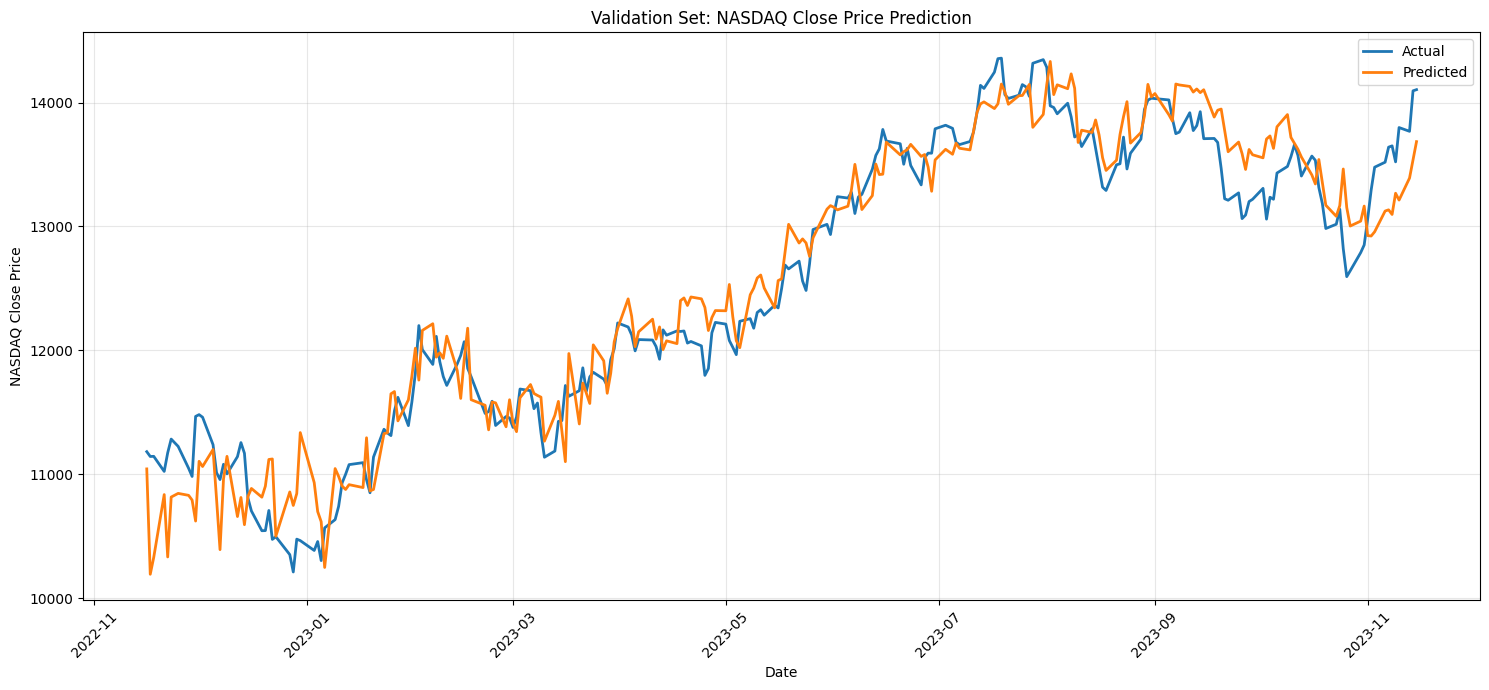


Test Set Performance Metrics:
MSE: 142227.74
RMSE: 377.13
MAE: 307.85
R2 Score: 0.9168


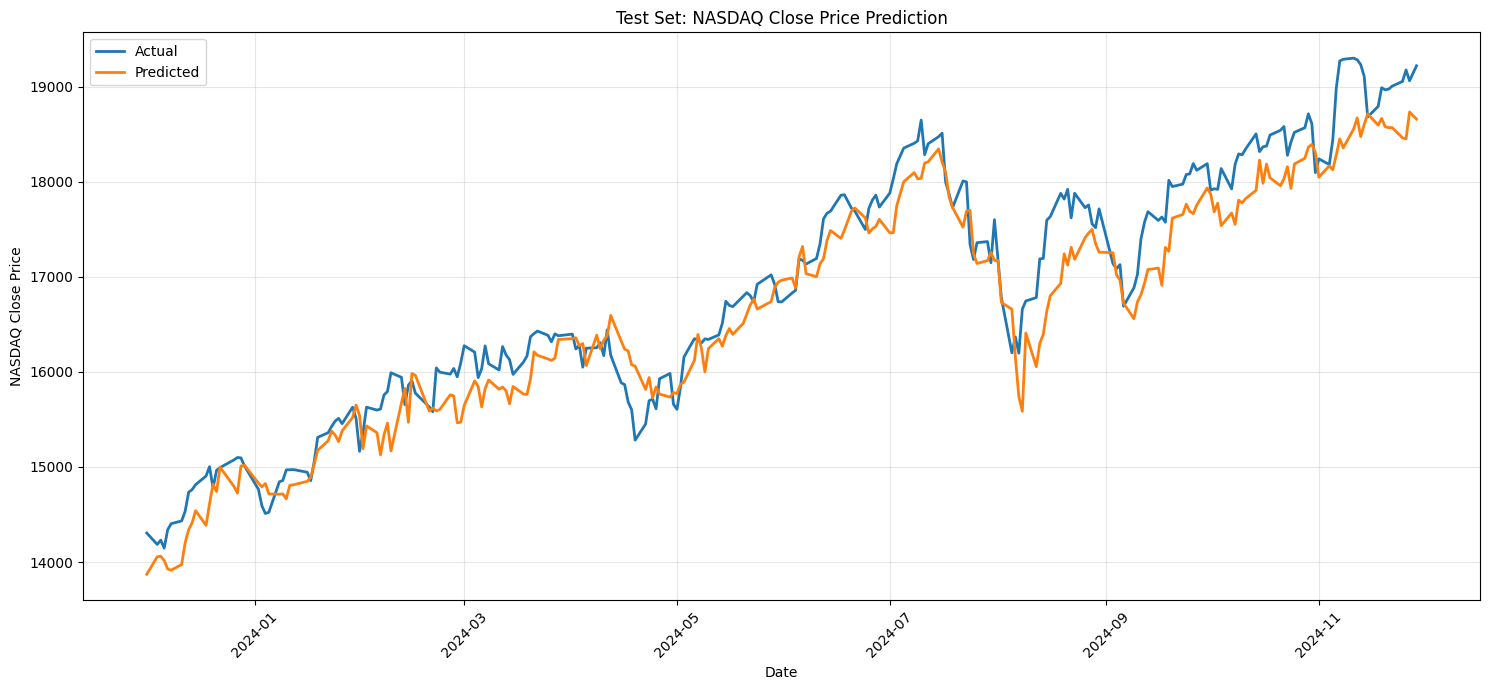

In [142]:
##########################################################################

#@title Create predictions with Best Params
def make_predictions(model, data_loader, scaler, data_columns):
    model.eval()  # Set model to evaluation mode
    predictions = []
    actuals = []

    with torch.no_grad():
        for features, targets in data_loader:
            output = model(features).squeeze()
            predictions.extend(output.numpy())
            actuals.extend(targets.numpy())

    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)

    predictions_dummy = np.zeros((len(predictions), len(data_columns)))
    actuals_dummy = np.zeros((len(actuals), len(data_columns)))

    nasdaq_idx = data_columns.index('nasdaq_close')
    predictions_dummy[:, nasdaq_idx] = predictions[:, 0]
    actuals_dummy[:, nasdaq_idx] = actuals[:, 0]

    predictions = scaler.inverse_transform(predictions_dummy)[:, nasdaq_idx]
    actuals = scaler.inverse_transform(actuals_dummy)[:, nasdaq_idx]

    return predictions, actuals

# Validation Set Evaluation
val_predictions, val_actuals = make_predictions(final_model, val_loader, scaler, data_columns)
val_metrics = calculate_metrics(val_actuals, val_predictions, "Validation Set")

# Plot validation predictions
plt.figure(figsize=(15, 7))
val_dates = data.index[train_size:train_size+val_size][-len(val_predictions):]
plt.plot(val_dates, val_actuals, label='Actual', linewidth=2)
plt.plot(val_dates, val_predictions, label='Predicted', linewidth=2)
plt.title('Validation Set: NASDAQ Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('NASDAQ Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Test Set Evaluation
test_predictions, test_actuals = make_predictions(final_model, test_loader, scaler, data_columns)
test_metrics = calculate_metrics(test_actuals, test_predictions, "Test Set")

# Plot test predictions
plt.figure(figsize=(15, 7))
test_dates = data.index[train_size+val_size:][-len(test_predictions):]
plt.plot(test_dates, test_actuals, label='Actual', linewidth=2)
plt.plot(test_dates, test_predictions, label='Predicted', linewidth=2)
plt.title('Test Set: NASDAQ Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('NASDAQ Close Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



---



In [122]:
print("Model:", model)
print("Model:", final_model)
print("Data Columns:", data_columns)

Model: TimeSeriesAttention(
  (attention): Linear(in_features=256, out_features=1, bias=True)
  (fc1): Linear(in_features=80, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)
Model: TimeSeriesAttention(
  (attention): Linear(in_features=128, out_features=1, bias=True)
  (fc1): Linear(in_features=80, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)
Data Columns: ['nasdaq_close', 'sp500_close', 'DGS10', 'VIXCLS', 'log_nasdaq', 'log_sp500', 'nasdaq_returns', 'sp500_returns', 'nasdaq_volatility', 'nasdaq_ma50', 'sp500_ma50', 'relative_strength']


In [143]:
print(best_params)

{'sequence_length': 10, 'batch_size': 32, 'hidden_size': 128, 'learning_rate': 0.0003, 'dropout_rate': 0.2}




---



In [144]:
#@title Save the model checkpoint (weights)
torch.save(final_model.state_dict(), 'final_model_checkpoint.pth')

In [157]:
#@title Load the model
loaded_model = TimeSeriesAttention(
    input_size=best_params['sequence_length'] * len(features),
    hidden_size=128,
    num_classes=1,
    dropout_rate=0.2
)
loaded_model.load_state_dict(torch.load('final_model_checkpoint.pth', weights_only=True))
loaded_model.eval() # Set to evaluation mode

TimeSeriesAttention(
  (attention): Linear(in_features=128, out_features=1, bias=True)
  (fc1): Linear(in_features=80, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

## Next Steps

Some potential areas for improvement include:
- Implement feature importance analysis to understand which features are most crucial
- Try different model architectures (e.g., LSTM, GRU, Transformer)
- Experiment with different sequence lengths and prediction horizons
- Implement walk-forward validation for a more robust evaluation
- Consider ensemble methods, combining predictions from multiple models
- Incorporate more features, possibly including sentiment analysis or economic indicators
- Implement proper backtesting procedures to simulate real-world trading scenarios
- Consider using techniques like Monte Carlo dropout for uncertainty estimation in predictions

1) Feature importance analysis to understand which features are most crucial for our time series forecasting model. We'll use a method called permutation importance, which measures how much the model's performance decreases when a feature is randomly shuffled. This approach works well with any model and doesn't require retraining.